In [13]:
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import matplotlib.pyplot as plt

In [14]:
# Define the path to the dataset
data_dir = os.path.abspath('american_sign_language')
# General image parameters
batch_size = 32
img_height = 150
img_width = 150
channels = 3
seed = 42

In [15]:
# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    label_mode='int',
    seed=seed)
# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    label_mode='int',
    seed=seed)

Found 19550 files belonging to 28 classes.
Using 15640 files for training.
Found 19550 files belonging to 28 classes.
Using 3910 files for validation.


In [16]:
# Print the class names
class_names = train_ds.class_names
print(class_names)

['a', 'b', 'c', 'close', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'open', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [17]:
conv_base = keras.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, channels),
)
conv_base.trainable = False

In [18]:
conv_base.summary()

Model: "convnext_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_prestem_normaliz  (None, 150, 150, 3)  0          ['input_2[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 37, 37, 128)  6528       ['convnext_base_prestem_normaliza
 )                                                               tion[0][0]']         

In [19]:
model_convnext = Sequential()
model_convnext.add(conv_base)
model_convnext.add(Flatten())
model_convnext.add(Dropout(0.1))
model_convnext.add(Dense(1024, activation='relu'))
model_convnext.add(Dropout(0.1))
model_convnext.add(Dense(512, activation='relu'))
model_convnext.add(Dropout(0.1))
model_convnext.add(Dense(len(train_ds.class_names), activation='sigmoid'))

In [20]:
model_convnext.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 4, 4, 1024)        87566464  
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_6 (Dropout)         (None, 16384)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              16778240  
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_8 (Dropout)         (None, 512)              

In [21]:
model_convnext.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history_convnext = model_convnext.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
489/489 [==============================] - 213s 402ms/step - loss: 0.6248 - accuracy: 0.8667 - val_loss: 0.0947 - val_accuracy: 0.9724
Epoch 2/10
489/489 [==============================] - 191s 391ms/step - loss: 0.1419 - accuracy: 0.9570 - val_loss: 0.0560 - val_accuracy: 0.9831
Epoch 3/10
489/489 [==============================] - 189s 387ms/step - loss: 0.0884 - accuracy: 0.9755 - val_loss: 0.1104 - val_accuracy: 0.9716
Epoch 4/10
489/489 [==============================] - 190s 388ms/step - loss: 0.1320 - accuracy: 0.9699 - val_loss: 0.0907 - val_accuracy: 0.9780
Epoch 5/10
489/489 [==============================] - 189s 387ms/step - loss: 0.0836 - accuracy: 0.9804 - val_loss: 0.0505 - val_accuracy: 0.9890
Epoch 6/10
489/489 [==============================] - 189s 387ms/step - loss: 0.0600 - accuracy: 0.9848 - val_loss: 0.0655 - val_accuracy: 0.9852
Epoch 7/10
489/489 [==============================] - 189s 387ms/step - loss: 0.0931 - accuracy: 0.9782 - val_loss: 0.0381 -

In [23]:
# Save the model
model_convnext.save("asl_model")

INFO:tensorflow:Assets written to: asl_model\assets


INFO:tensorflow:Assets written to: asl_model\assets


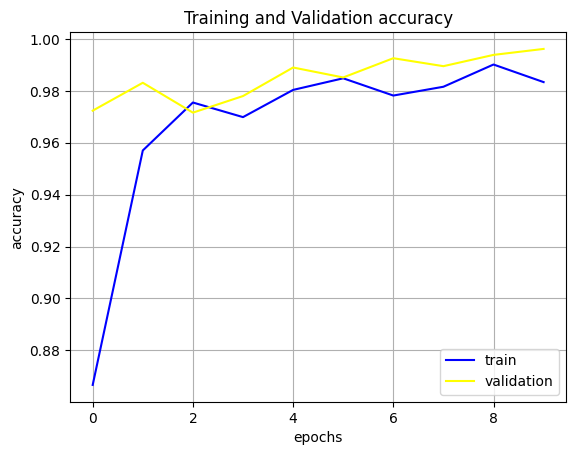

In [24]:
plt.plot(history_convnext.history['accuracy'], color='blue', label='train')
plt.plot(history_convnext.history['val_accuracy'], color='yellow', label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.grid()
plt.show()

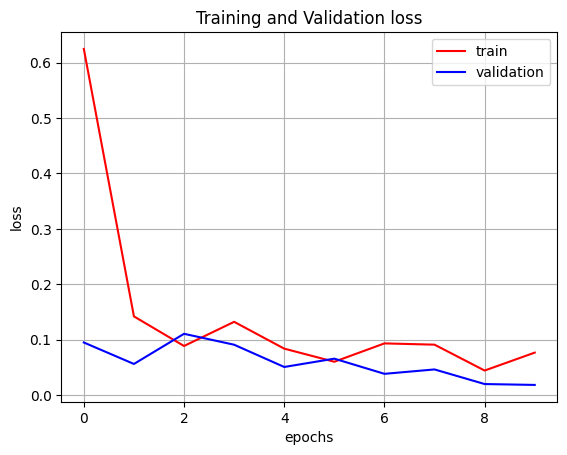

In [25]:
plt.plot(history_convnext.history['loss'], color='red', label='train')
plt.plot(history_convnext.history['val_loss'], color='blue', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.legend()
plt.grid()
plt.show()

In [26]:
# Make some predictions on the validation dataset
images_list = []
labels_list = []
for images, labels in val_ds.take(1):
    images_list.append(images)
    labels_list.append(labels.numpy())
    predictions = np.argmax(model_convnext.predict(images_list), axis=-1)

1/1 [==============================] - 2s 2s/step


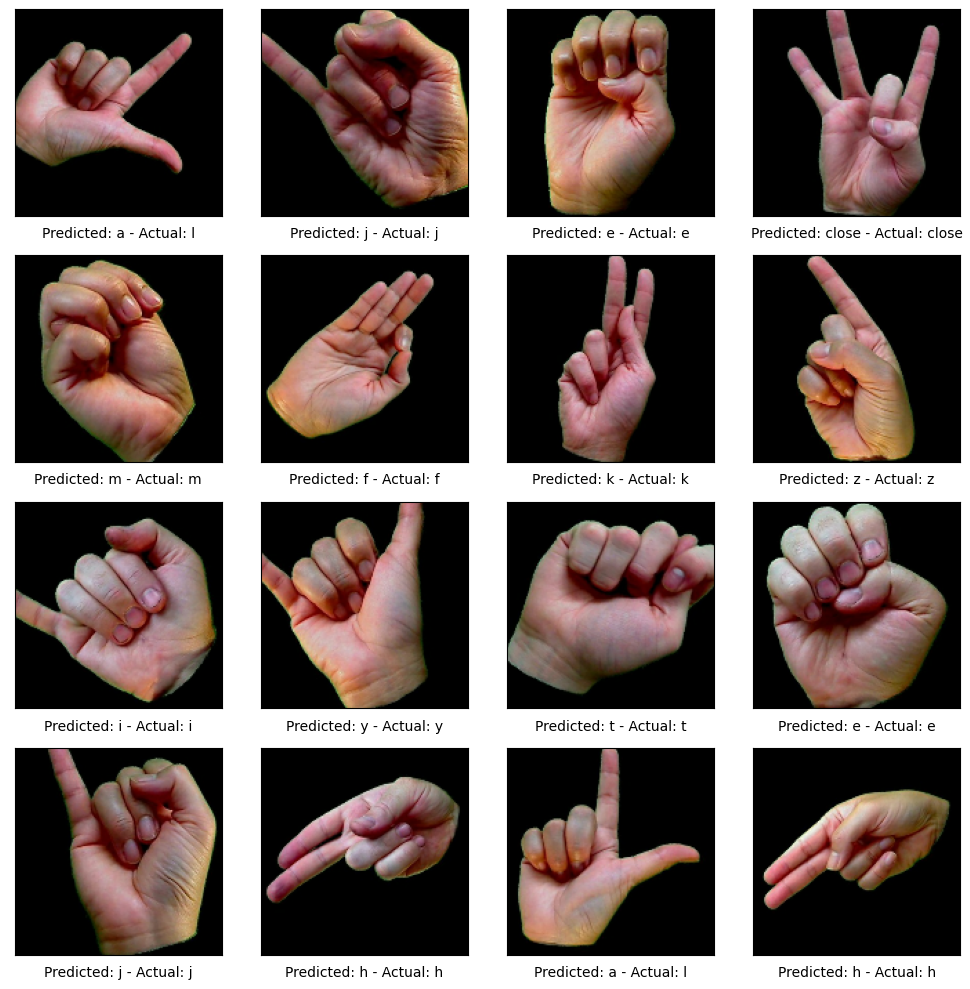

In [28]:
# Plot the predictions
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_list[0][i].numpy().astype("uint8"))
    plt.xlabel(f"Predicted: {class_names[predictions[i]]} - Actual: {class_names[labels_list[0][i]]}")
plt.tight_layout()